## generalization

- https://en.wikipedia.org/wiki/Stars_and_bars_(combinatorics)

---

In [1]:
include("carlin.jl")

In [2]:
using ReachabilityAnalysis, LinearAlgebra, Plots

We conside the one-dimensional [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation).

Numerical values are obtained from [^LKKLTC20].

In [25]:
# Numerical constants

using LinearAlgebra

n = 16 # discretization points
ν = 0.05 # kinematic viscosity
Δx = 1.0/(n-1)
c1 = ν/Δx^2
c2 = 1/(4Δx)

3.75

In [26]:
# Burgers equation
#=
@taylorize function burgers!(du, u, p, t)
    du[1] = zero(u[1])
    du[n] = zero(u[nn])
    for i in 2:n-1
        du[i] = c1*(u[i-1]-2*u[i]+u[i+1]) - c2*(u[i+1]^2 - u[i-1]^2)
    end
end
=#

# remove endpoints
@taylorize function burgers!(du, u, p, t)
    du[1] = c1*(-2*u[1]+u[2]) - c2*(u[2]^2)
    du[n] = c1*(u[n-1]-2*u[n]) - c2*(-u[n-1]^2)
    for i in 2:n-1
        du[i] = c1*(u[i-1]-2*u[i]+u[i+1]) - c2*(u[i+1]^2 - u[i-1]^2)
    end
end

L0 = 1. # domain length
U0 = 1. # Re = 20.
x = range(-0.5*L0, 0.5*L0, length=n)

# Initial velocity
X0 = Singleton(-U0*sin.(2*π/L0*x))

# IVP definition
prob = IVP(BlackBoxContinuousSystem(burgers!, n), X0);

$$
x' = F_1 x + F_2 (x \otimes x)
$$

$x\otimes x = x^{[2]} = (x_1^2, x_1x_2, x_1x_3, \ldots, x_1 x_n, x_2 x_1, x_2^2, \ldots, x_2 x_n, \ldots, x_n^2)^T$

In [27]:
#=
function _burgers(; n)
    
    dv = c1 * fill(-2.0, n)
    dv[1] = 0.0; dv[n] = 0.0

    ev = c1 * fill(1.0, n-1)
    ev[1] = 0.0; ev[n-1] = 0.0

    F1 = SymTridiagonal(dv, ev)

    F2 = zeros(n, n^2)
    x, = @polyvar x[1:n]
    y = kron(x, 2)

    for i in 2:n-1
        idx = findfirst(y, x[i-1]^2)
        F2[i, idx] = -1.0

        idx = findfirst(y, x[i+1]^2)
        F2[i, idx] = 1.0
    end
    F2 .*= -c2
    F2 = sparse(F2)
    
    return F1, F2
end
=#

# we remove the endpoints
function _burgers(; n)
    
    dv = c1 * fill(-2.0, n)
    ev = c1 * fill(1.0, n-1)

    F1 = SymTridiagonal(dv, ev)

    F2 = zeros(n, n^2)
    x, = @polyvar x[1:n]
    y = kron(x, 2)

    idx = findfirst(y, x[2]^2)
    F2[1, idx] = 1.0

    idx = findfirst(y, x[n]^2)
    F2[n, idx] = -1.0
    
    for i in 2:n-1
        idx = findfirst(y, x[i-1]^2)
        F2[i, idx] = -1.0

        idx = findfirst(y, x[i+1]^2)
        F2[i, idx] = 1.0
    end
    F2 .*= -c2
    F2 = sparse(F2)
    
    return F1, F2
end

_burgers (generic function with 1 method)

In [28]:
F1, F2 = _burgers(n=n);

In [29]:
ev = eigvals(F1)

16-element Array{Float64,1}:
 -44.6168947428878
 -43.480625161598006
 -41.62988555391632
 -39.127700637464834
 -36.05927931853326
 -32.52911300497212
 -28.657417276621878
 -24.576038087924292
 -20.423961912075715
 -16.342582723378136
 -12.470886995027888
  -8.940720681466741
  -5.872299362535174
  -3.3701144460836914
  -1.5193748384019927
  -0.3831052571122082

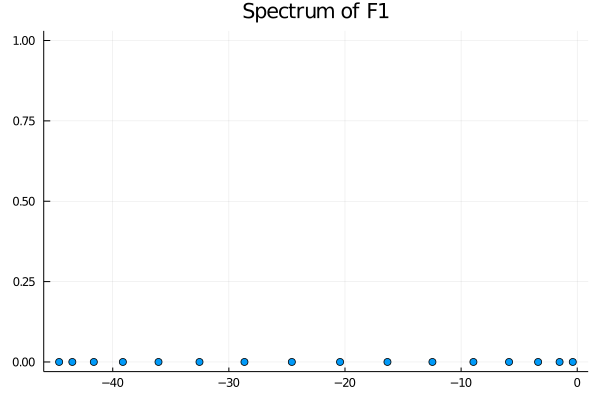

In [30]:
plot(real(ev), imag(ev), st=:scatter, lab="", title="Spectrum of F1")

## Solution with TMJets

In [31]:
GC.gc()

In [32]:
@time sol = solve(prob, tspan=(0.0, 4.0), alg=TMJets());

 73.650104 seconds (622.43 M allocations: 48.231 GiB, 12.95% gc time)


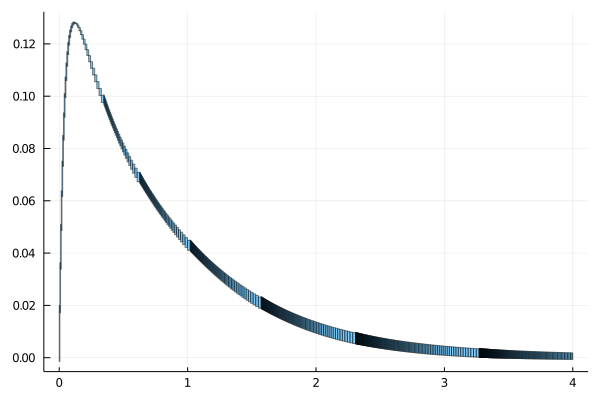

In [33]:
plot(sol, vars=(0, 1))

## Carlin error bound function